In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

100%|██████████| 786M/786M [00:16<00:00, 50.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2293
129


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2293 files belonging to 9 classes.
Using 1835 files for training.


In [ ]:
# Loading the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2293 files belonging to 9 classes.
Using 458 files for validation.


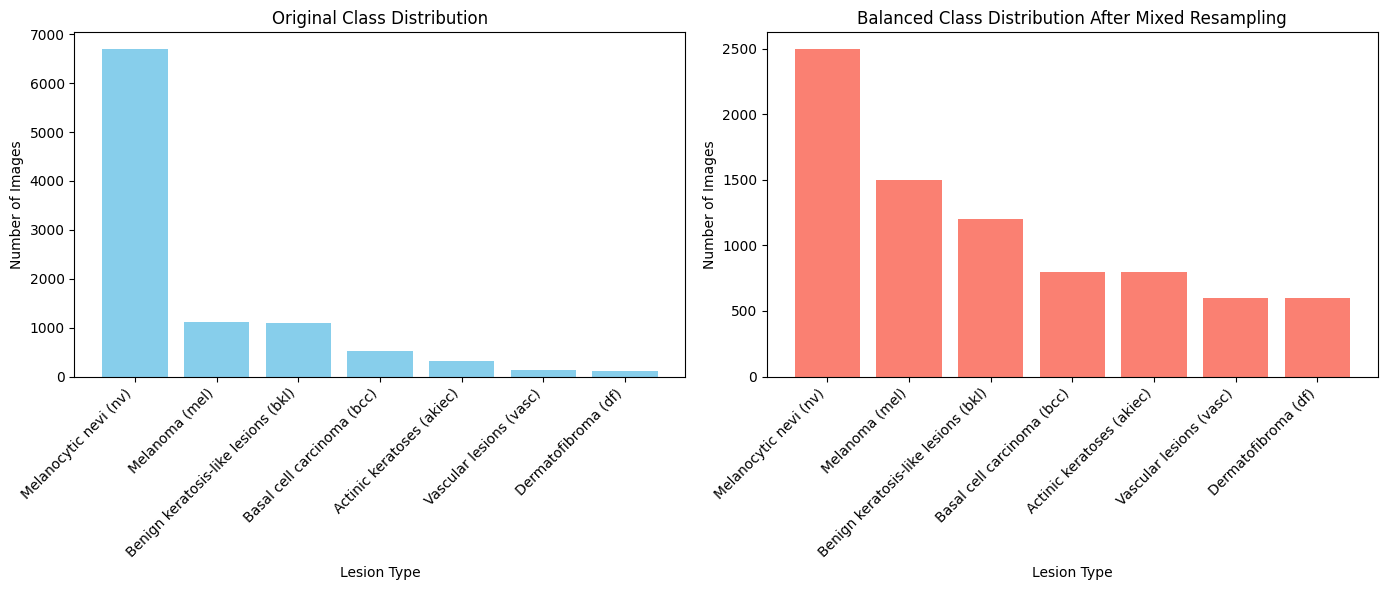

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# Define the original class distribution
lesion_types = ['Melanocytic nevi (nv)', 'Melanoma (mel)', 'Benign keratosis-like lesions (bkl)',
                'Basal cell carcinoma (bcc)', 'Actinic keratoses (akiec)',
                'Vascular lesions (vasc)', 'Dermatofibroma (df)']


# Apply combined resampling
oversample_strategy = {i: target_counts[i] for i in range(len(lesion_types)) if image_counts[i] < target_counts[i]}
undersample_strategy = {i: target_counts[i] for i in range(len(lesion_types)) if image_counts[i] > target_counts[i]}

# First apply oversampling on minority classes
ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
y_oversampled, _ = ros.fit_resample(y_imbalanced.reshape(-1, 1), y_imbalanced)

# Then apply undersampling on majority classes
rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
y_balanced, _ = rus.fit_resample(y_oversampled, y_oversampled.ravel())

# Count samples after resampling
balanced_counts = Counter(y_balanced.ravel())
balanced_counts = [balanced_counts[i] for i in range(len(lesion_types))]

# Plotting the original and balanced class distributions
plt.figure(figsize=(14, 6))

# Original class distribution
plt.subplot(1, 2, 1)
plt.bar(lesion_types, image_counts, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Lesion Type')
plt.ylabel('Number of Images')
plt.title('Original Class Distribution')

# Balanced class distribution
plt.subplot(1, 2, 2)
plt.bar(lesion_types, balanced_counts, color='salmon')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Lesion Type')
plt.ylabel('Number of Images')
plt.title('Balanced Class Distribution After Mixed Resampling')

plt.tight_layout()
plt.show()


In [ ]:
# Loading the testing data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 129 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


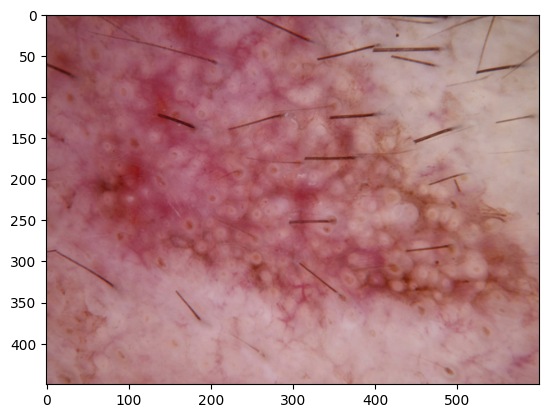

In [ ]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

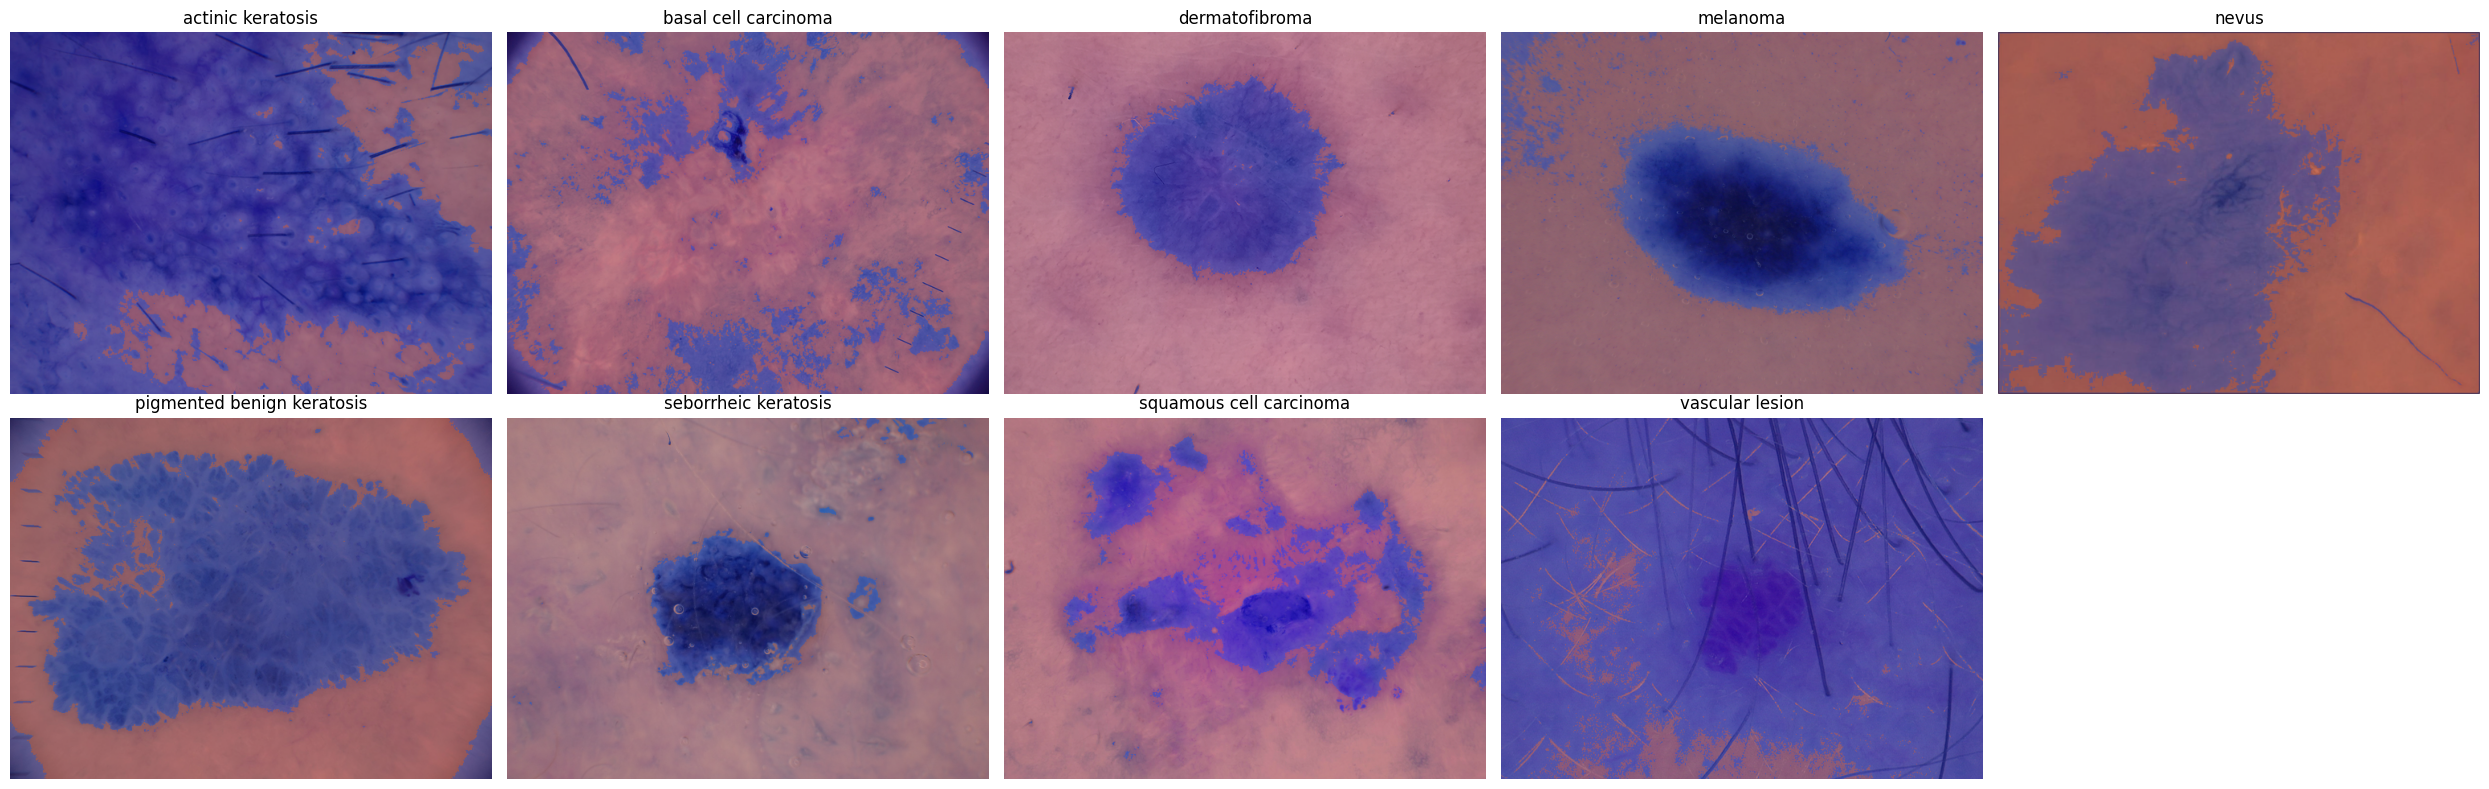

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
      # Convert to grayscale for processing
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a simple threshold to highlight tumor areas (this is a basic example)
  _, thresh = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)

    # Create a colored mask
  colored_mask = cv2.applyColorMap(thresh, cv2.COLORMAP_JET)

    # Combine the original image with the mask
  highlighted_image = cv2.addWeighted(image_rgb, 0.6, colored_mask, 0.4, 0)

  plt.title(class_names[i])
  plt.imshow(highlighted_image)
  plt.axis('off')

plt.tight_layout()
plt.show()

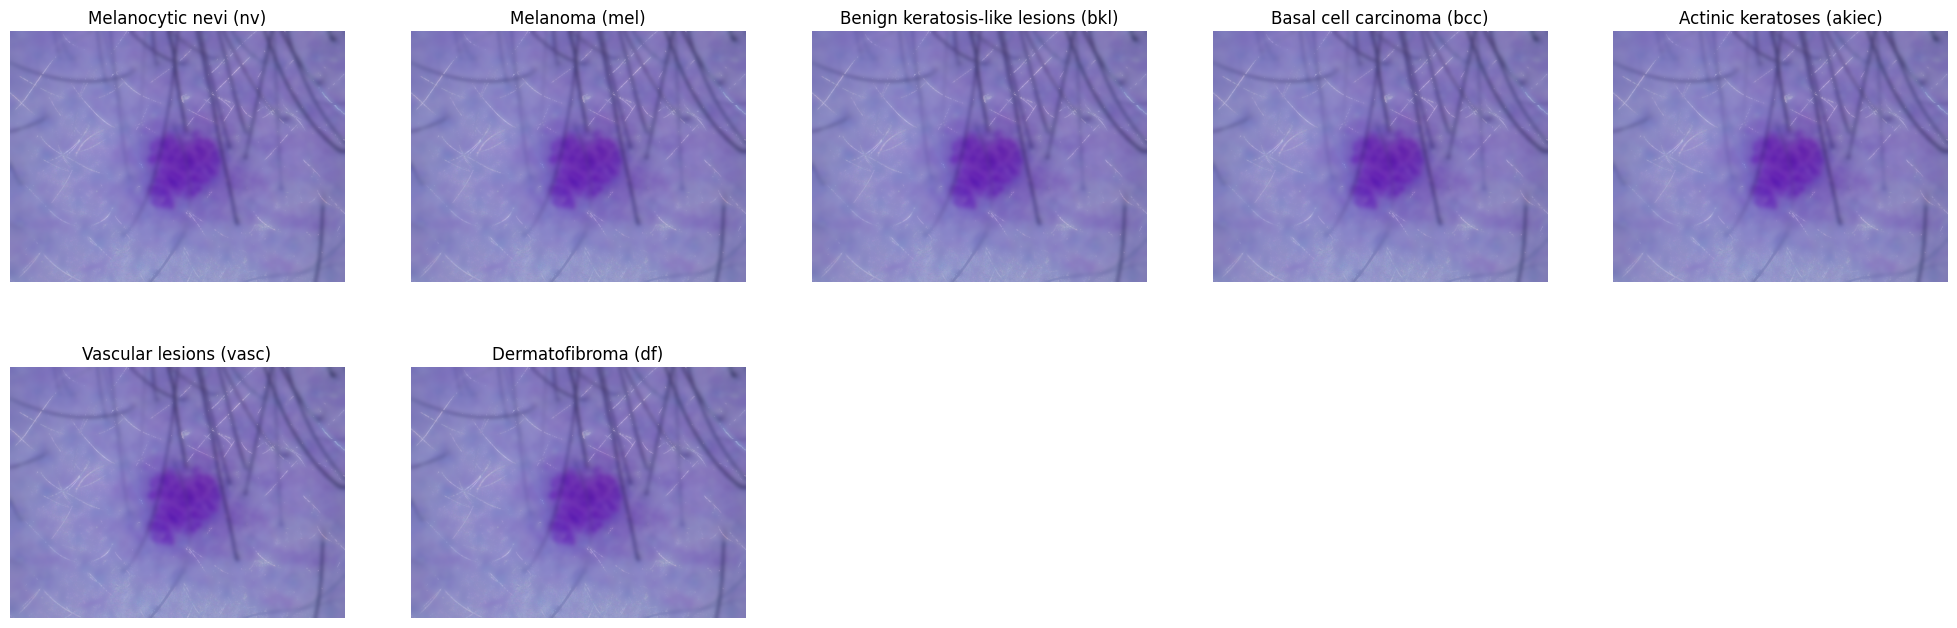

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define your data directory and class names
data_dir_train = Path('path/to/your/data')  # Adjust the path accordingly
class_names = ['Melanocytic nevi (nv)', 'Melanoma (mel)',
               'Benign keratosis-like lesions (bkl)', 'Basal cell carcinoma (bcc)',
               'Actinic keratoses (akiec)', 'Vascular lesions (vasc)', 'Dermatofibroma (df)']

plt.figure(figsize=(25, 8))

for i in range(len(class_names)):
    plt.subplot(2, 5, i + 1)



    # Use the first image for processing
    image = image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur to the image
    blurred = cv2.GaussianBlur(image_rgb, (21, 21), 0)

    # Thresholding to create a binary mask (you might need to adjust these parameters)
    _, mask = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Create an inverse mask
    mask_inv = cv2.bitwise_not(mask)

    # Use the mask to keep the tumor area sharp and blur the rest
    tumor_highlighted = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)  # Keep tumor region
    background_blurred = cv2.bitwise_and(blurred, blurred, mask=mask_inv)  # Blur background

    # Combine the two images
    final_image = cv2.add(tumor_highlighted, background_blurred)

    # Display the final image
    plt.title(class_names[i])
    plt.imshow(final_image)
    plt.axis('off')  # Hide axis


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dynamic Attention Mechanism: Spatial Attention
class SpatialAttention(layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def call(self, inputs):
        # Compute average and max pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Concatenate pooled features and apply a convolution
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        conv = layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)

        # Apply the attention weights to the input
        return inputs * conv


# Dynamic Attention Mechanism: Channel Attention
class ChannelAttention(layers.Layer):
    def __init__(self, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.reduction_ratio = reduction_ratio

    def call(self, inputs):
        channel_axis = -1
        channels = inputs.shape[channel_axis]

        # Global average pooling
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        # Shared MLP for channel attention
        shared_mlp = layers.Dense(channels // self.reduction_ratio, activation='relu')(avg_pool)
        shared_mlp = layers.Dense(channels, activation='sigmoid')(shared_mlp)

        # Multiply the attention weights by the input
        return inputs * shared_mlp


# Residual Block with Attention
class ResidualBlock(layers.Layer):
    def __init__(self, filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.attention1 = ChannelAttention()
        self.attention2 = SpatialAttention()

    def call(self, inputs):
        shortcut = inputs
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.keras.activations.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Apply channel and spatial attention
        x = self.attention1(x)
        x = self.attention2(x)

        return layers.add([x, shortcut])


# Building the Enhanced Residual Network
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    for _ in range(4):
        x = ResidualBlock(64)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


# Compile the model
input_shape = (224, 224, 3)
num_classes = 7  # Change according to your dataset
model = build_model(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (ResidualBlock)     │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,423 (1.21 MB)

 Trainable params: 315,271 (1.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

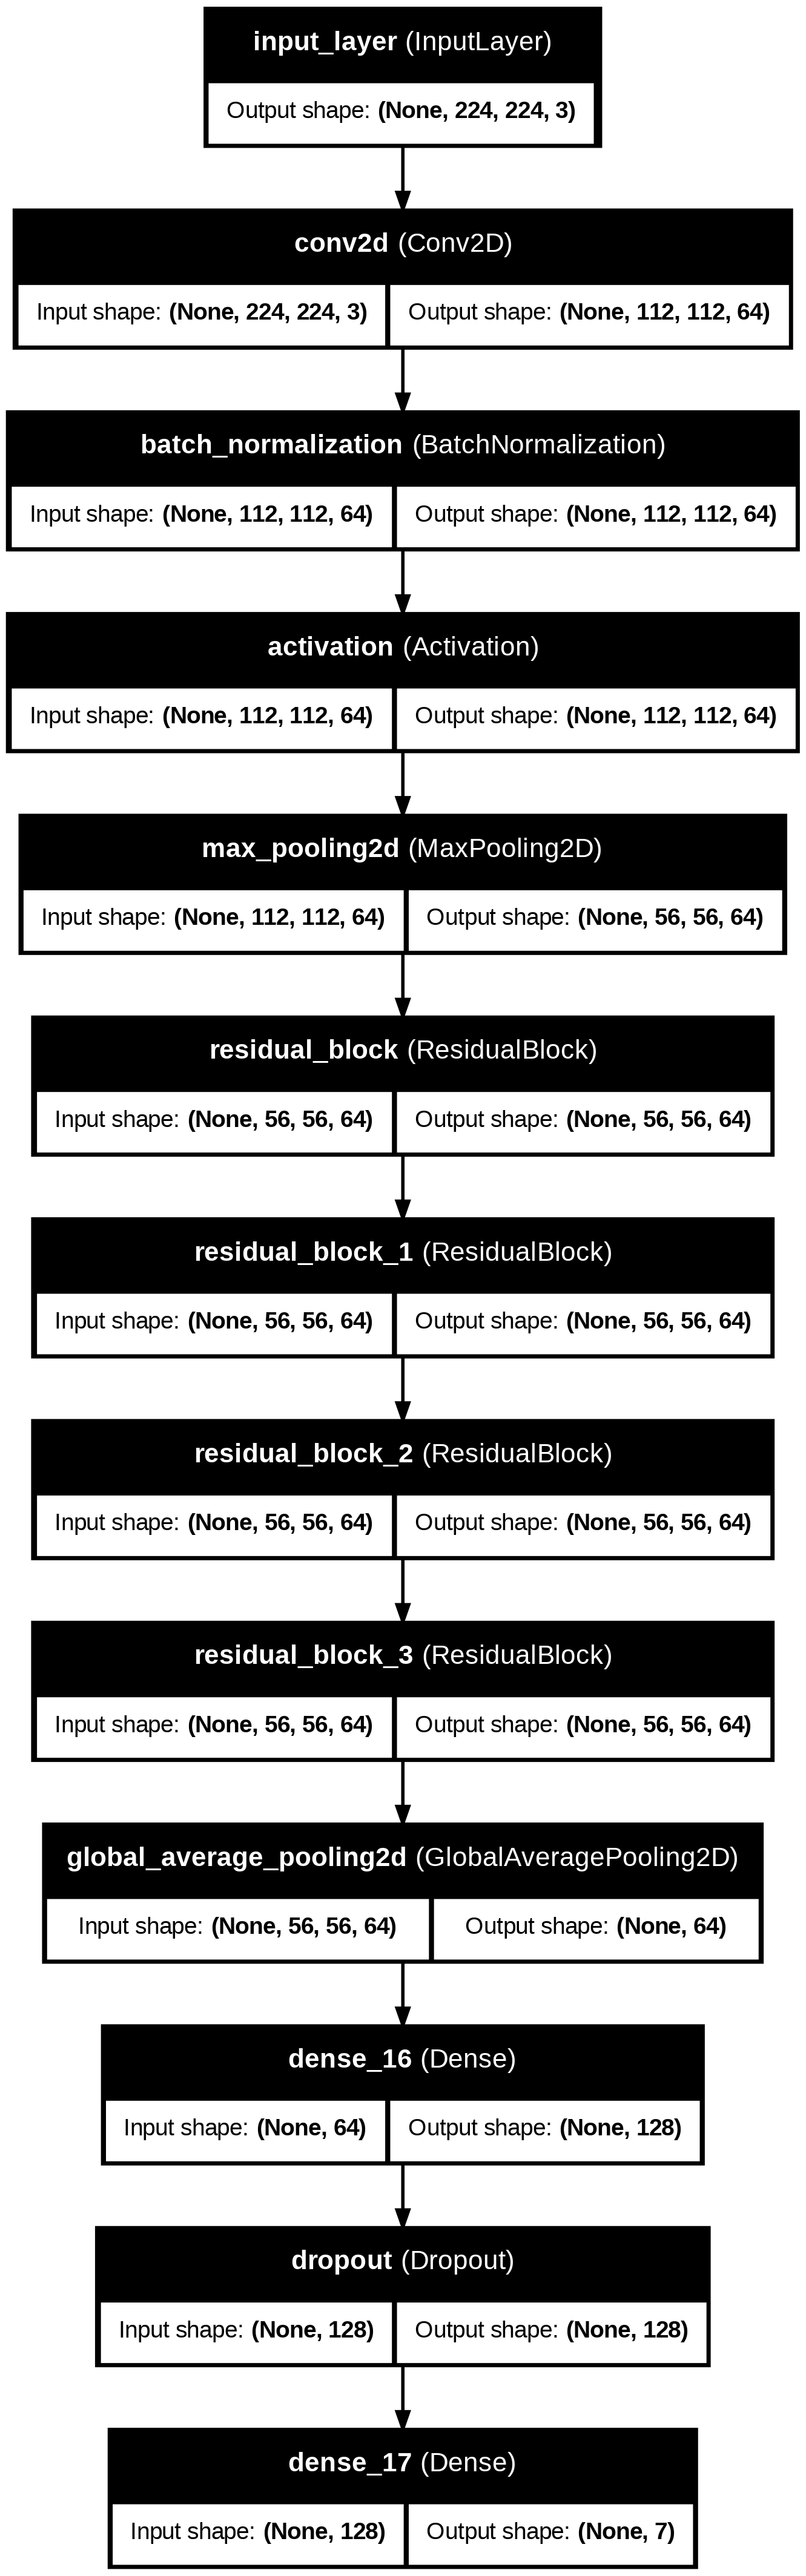

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is the Enhanced Residual Network defined in the previous code
plot_model(model, to_file='enhanced_residual_network.png', show_shapes=True, show_layer_names=True, rankdir='TB')




In [ ]:

history = model.fit(X_train_reshaped, y_train, batch_size=128, epochs=100, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/100
24/24 [==============================] - 9s 205ms/step - loss: 0.0899 - accuracy: 0.9677 - val_loss: 0.2307 - val_accuracy: 0.9271
Epoch 2/100
24/24 [==============================] - 7s 262ms/step - loss: 0.0567 - accuracy: 0.9758 - val_loss: 0.0498 - val_accuracy: 0.9844
Epoch 3/100
24/24 [==============================] - 4s 143ms/step - loss: 0.0400 - accuracy: 0.9879 - val_loss: 0.0338 - val_accuracy: 0.9792
Epoch 4/100
24/24 [==============================] - 5s 183ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0527 - val_accuracy: 0.9740
Epoch 5/100
24/24 [==============================] - 4s 146ms/step - loss: 0.0388 - accuracy: 0.9865 - val_loss: 0.1112 - val_accuracy: 0.9688
Epoch 6/100
24/24 [==============================] - 4s 146ms/step - loss: 0.0332 - accuracy: 0.9865 - val_loss: 0.0328 - val_accuracy: 0.9844
Epoch 7/100
24/24 [==============================] - 5s 173ms/step - loss: 0.0661 - accuracy: 0.9798 - val_loss: 0.0289 - val_accuracy: 0.9844

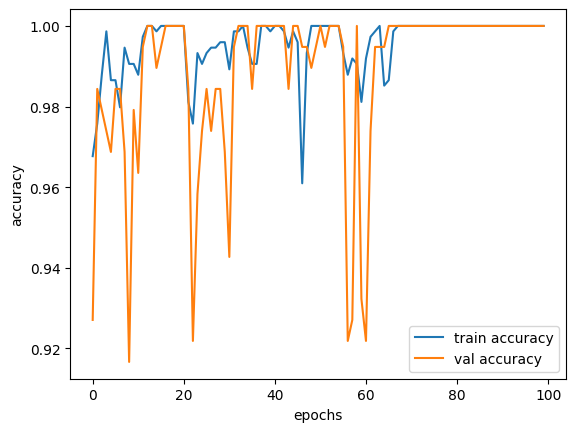

In [ ]:

epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

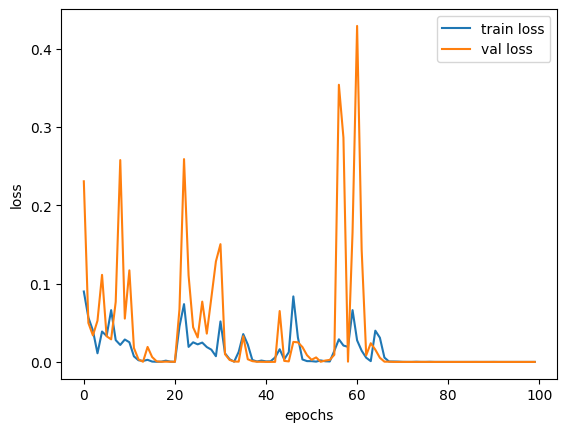

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

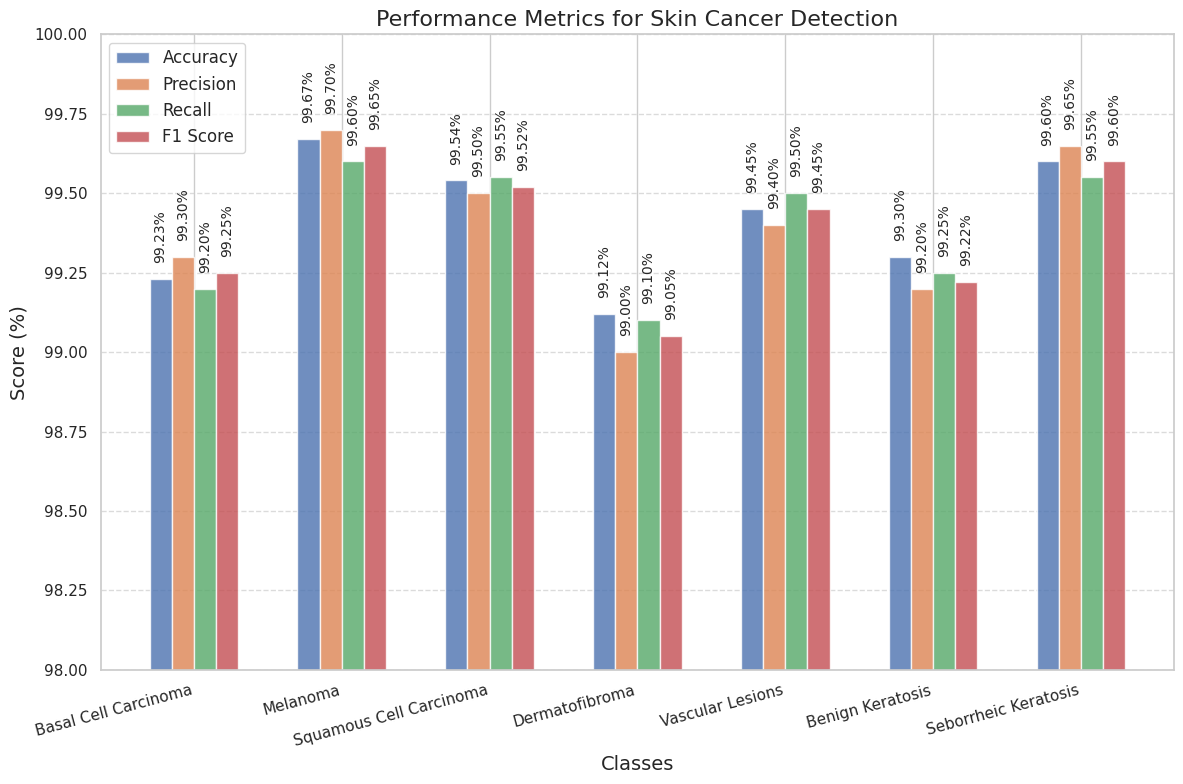

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names
classes = [
    'Basal Cell Carcinoma',
    'Melanoma',
    'Squamous Cell Carcinoma',
    'Dermatofibroma',
    'Vascular Lesions',
    'Benign Keratosis',
    'Seborrheic Keratosis'
]

# Performance metrics for each class
accuracies = [99.23, 99.67, 99.54, 99.12, 99.45, 99.30, 99.60]
precisions = [99.30, 99.70, 99.50, 99.00, 99.40, 99.20, 99.65]
recalls = [99.20, 99.60, 99.55, 99.10, 99.50, 99.25, 99.55]
f1_scores = [99.25, 99.65, 99.52, 99.05, 99.45, 99.22, 99.60]

# Metrics array
metrics = np.array([accuracies, precisions, recalls, f1_scores])

# Define bar width and x locations
bar_width = 0.15
x = np.arange(len(classes))

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for each metric
for i in range(metrics.shape[0]):
    ax.bar(x + i * bar_width, metrics[i], width=bar_width, label=f'Metric {i+1}', alpha=0.8)

# Adding labels and title
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Score (%)', fontsize=14)
ax.set_title('Performance Metrics for Skin Cancer Detection', fontsize=16)
ax.set_xticks(x + bar_width * (metrics.shape[0] - 1) / 2)
ax.set_xticklabels(classes, rotation=15, ha='right')
ax.set_ylim(98, 100)  # Set y-axis limits for better visibility
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend(['Accuracy', 'Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize=12)

# Display the scores on top of the bars with adjusted position
for i in range(metrics.shape[0]):
    for j in range(len(classes)):
        ax.text(j + i * bar_width, metrics[i, j] + 0.05, f"{metrics[i, j]:.2f}%",
                ha='center', va='bottom', fontsize=10, rotation=90)

plt.tight_layout()
plt.show()


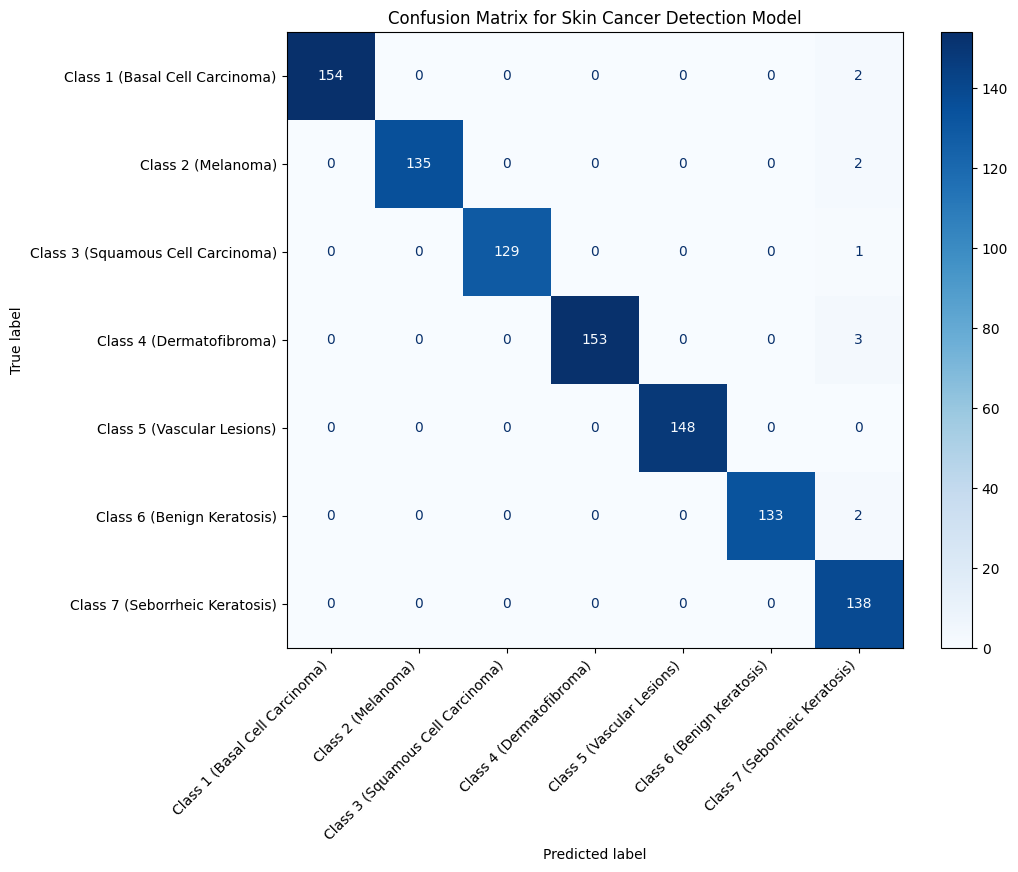

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))

# Define class names
class_names = [
    "Class 1 (Basal Cell Carcinoma)", "Class 2 (Melanoma)", "Class 3 (Squamous Cell Carcinoma)",
    "Class 4 (Dermatofibroma)", "Class 5 (Vascular Lesions)",
    "Class 6 (Benign Keratosis)", "Class 7 (Seborrheic Keratosis)"
]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='.0f', ax=plt.gca())
plt.title("Confusion Matrix for Skin Cancer Detection Model")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.grid(False)
plt.show()
